In [59]:
#import libraries
import time
import math
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Support Functions

In [ ]:
# Support function to be able to create multiple pairewise heatmaps
def plot_heatmap_age(df, x_col_name, y_col_name,plot_title):
    plot_title = str(plot_title)
    sns.set(style='whitegrid', font_scale=1.2)
    heatmap_data = df.pivot_table(values=y_col_name, index=x_col_name, aggfunc=np.mean)
    sns.heatmap(heatmap_data, cmap='YlOrRd')
    plt.xlabel(x_col_name)
    plt.ylabel(y_col_name)
    plt.title(plot_title)
    # Save the plot to a PDF file
    plt.savefig(f'{plot_title}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

## Load Dataset

In [2]:
# File Paths:
#bike_stop = "add_path"
bike_activity = "add_path_bike"


In [33]:
bike_df = pd.read_csv(bike_activity, header = 0, sep = ';')

In [34]:
# Quick check on df shape and first instances
print(f"movements df size: {bike_df.shape}")
print("")
print(f"Data types:\n {bike_df.dtypes}")
print("")
print(f"Null values check:\n {bike_df.isnull().sum()}")
display(bike_df.head())

movements df size: (3956191, 16)

Data types:
 _id                     object
user_day_code           object
idplug_base              int64
user_type                int64
idunplug_base            int64
travel_time              int64
idunplug_station         int64
ageRange                 int64
idplug_station           int64
unplug_hourTime         object
zip_code                object
temp_unplug_hourTime    object
year                     int64
month                    int64
day                      int64
hour                     int64
dtype: object

Null values check:
 _id                           0
user_day_code                 0
idplug_base                   0
user_type                     0
idunplug_base                 0
travel_time                   0
idunplug_station              0
ageRange                      0
idplug_station                0
unplug_hourTime               0
zip_code                1953533
temp_unplug_hourTime          0
year                          0
month 

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code,temp_unplug_hourTime,year,month,day,hour
0,5c4b07ea2f38432e007daab8,b3b5b61509ab89afbf4d1e589d229bebe6637c2de819f5...,14,1,23,162,82,0,83,2019-01-01T00:00:00.000+0100,NaN,2019-01-01 00:00:00+01:00,2019,1,1,0
1,5c4b07ea2f38432e007daaba,a18550d468153bb8e1808d4f0a85955579951832772996...,10,1,1,415,133,5,36,2019-01-01T00:00:00.000+0100,28005,2019-01-01 00:00:00+01:00,2019,1,1,0
2,5c4b07ea2f38432e007daabb,905737396c2fe343c84d62eaee3ab66e19632638c5bea7...,5,1,3,545,25,0,90,2019-01-01T00:00:00.000+0100,NaN,2019-01-01 00:00:00+01:00,2019,1,1,0
3,5c4b07ea2f38432e007daabd,5922b4a1a2591161ebf1ad66f42f52cc7796f3754c2c76...,18,1,6,417,105,3,155,2019-01-01T00:00:00.000+0100,28009,2019-01-01 00:00:00+01:00,2019,1,1,0
4,5c4b07ea2f38432e007daabe,ed1c1a22c120e7d42cc522c33ab41db549791f3914b273...,4,1,12,448,51,4,44,2019-01-01T00:00:00.000+0100,28005,2019-01-01 00:00:00+01:00,2019,1,1,0


In [35]:
display(bike_df['hour'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [36]:
# Adding new column converting travel_time from sec to  min to be used for viz purposes 
bike_df['travel_time_min'] = bike_df['travel_time'].apply(lambda x: x/60)

## Data Exploration:

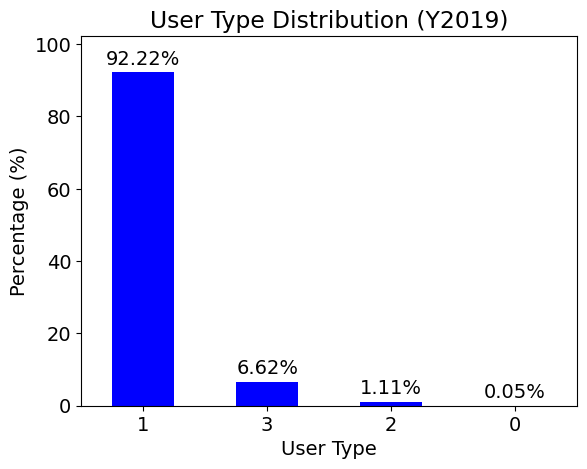

In [37]:
"""User type values {0:Unknown; 1:Annual subscription; 2:occasional user; 3:BiciMAD employee}"""

# User_type distribution
user_type_dist = (bike_df['user_type'].value_counts()/bike_df.shape[0])*100

# Set font size to be further exported for the paper
plt.rcParams.update({'font.size': 14})

# Create barplot
ax = user_type_dist.plot(kind='bar', rot=0, color=['blue'])

# Set ylim to ensure values on top of the bars do not overlap with the graph limits
ax.set_ylim(0, user_type_dist.max() + 10)

# Add values on top of each bar
for i, v in enumerate(user_type_dist):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', color='black')

plt.xlabel('User Type')
plt.ylabel('Percentage (%)')
plt.title('User Type Distribution (Y2019)')

# Save the plot to a PDF file
plt.savefig('tot_user_type_distribution.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [38]:
# Identify unknown user type:
unknown_users_df = bike_df[bike_df['user_type']==0]
display(f"To which ageRange does unknown users belong to: {unknown_users_df ['ageRange'].unique()}") # We don't have any info about users.
tot_unknown_users = len(bike_df[bike_df['user_type']==0])
display(f"% unknown users for year 2019: {(tot_unknown_users/bike_df.shape[0])*100}")


'To which ageRange does unknown users belong to: [0]'

'% unknown users for year 2019: 0.04673687392747216'

In [39]:
# We noticed BiciMAD disclose employee's ageRange values
bike_df[bike_df['user_type']==3]

,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code,temp_unplug_hourTime,year,month,day,hour,travel_time_min
1039,5c4b07f02f38432e007daf89,32de90d829ddeadfe35f013b3140bcc092c62b804d3dcc...,6,3,8,2119,129,0,112,2019-01-01T06:00:00.000+0100,NaN,2019-01-01 06:00:00+01:00,2019,1,1,6,35.3166666667
1040,5c4b07f02f38432e007daf85,32de90d829ddeadfe35f013b3140bcc092c62b804d3dcc...,4,3,6,2112,129,0,112,2019-01-01T06:00:00.000+0100,NaN,2019-01-01 06:00:00+01:00,2019,1,1,6,35.2000000000
1041,5c4b07f02f38432e007daf8b,32de90d829ddeadfe35f013b3140bcc092c62b804d3dcc...,7,3,9,2173,129,0,112,2019-01-01T06:00:00.000+0100,NaN,2019-01-01 06:00:00+01:00,2019,1,1,6,36.2166666667
1042,5c4b07f02f38432e007daf88,32de90d829ddeadfe35f013b3140bcc092c62b804d3dcc...,5,3,7,2144,129,0,112,2019-01-01T06:00:00.000+0100,NaN,2019-01-01 06:00:00+01:00,2019,1,1,6,35.7333333333
1043,5c4b07f02f38432e007daf8c,32de90d829ddeadfe35f013b3140bcc092c62b804d3dcc...,8,3,11,2155,129,0,112,2019-01-01T06:00:00.000+0100,NaN,2019-01-01 06:00:00+01:00,2019,1,1,6,35.9166666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955737,5eeb03df2ea8f656fc95f0cc,f2a5515672e852063a53eda2d2bbdc19d8b9f8a219163f...,3,3,2,3123,49,5,91,2019-12-31T19:00:00Z,28022,2019-12-31 19:00:00+00:00,2019,12,31,19,52.0500000000
3955741,5eeb03df2ea8f656fc95f0d1,f2a5515672e852063a53eda2d2bbdc19d8b9f8a219163f...,5,3,3,3170,49,5,91,2019-12-31T19:00:00Z,28022,2019-12-31 19:00:00+00:00,2019,12,31,19,52.8333333333
3955744,5eeb03df2ea8f656fc95f0d4,f2a5515672e852063a53eda2d2bbdc19d8b9f8a219163f...,7,3,6,3283,49,5,91,2019-12-31T19:00:00Z,28022,2019-12-31 19:00:00+00:00,2019,12,31,19,54.7166666667
3955750,5eeb03e02ea8f656fc95f0da,f2a5515672e852063a53eda2d2bbdc19d8b9f8a219163f...,8,3,7,3320,49,5,91,2019-12-31T19:00:00Z,28022,2019-12-31 19:00:00+00:00,2019,12,31,19,55.3333333333


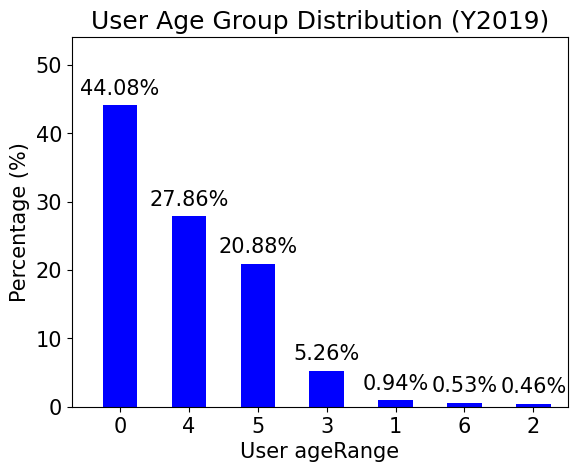

In [40]:
"""User ageRange values: {0:Unknown; 1:[0:16]; 2:[17:18]; 3:[19:26]; 4:[27:40]; 5:[41:65]; 6:[66:]}"""

# User Age group distribution w/o filtering
user_age_dist = (bike_df['ageRange'].value_counts()/bike_df.shape[0])*100 # Change bike_users_df to bike_df to display AS-IS age group distribution


# Set font size to be further exported for the paper
plt.rcParams.update({'font.size': 15})

# Create barplot
ax = user_age_dist.plot(kind='bar', rot=0, color=['blue'])

# Set ylim to ensure values on top of the bars do not overlap with the graph limits
ax.set_ylim(0, user_age_dist.max() + 10)



# Add values on top of each bar
for i, v in enumerate(user_age_dist):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', color='black')

# Adjust x-axis limits if necessary
ax.set_xlim(-0.7, len(user_age_dist) - 0.5)

plt.xlabel('User ageRange')
plt.ylabel('Percentage (%)')
plt.title('User Age Group Distribution (Y2019)')

# Save the plot to a PDF file
plt.savefig('user_age_group_distribution.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


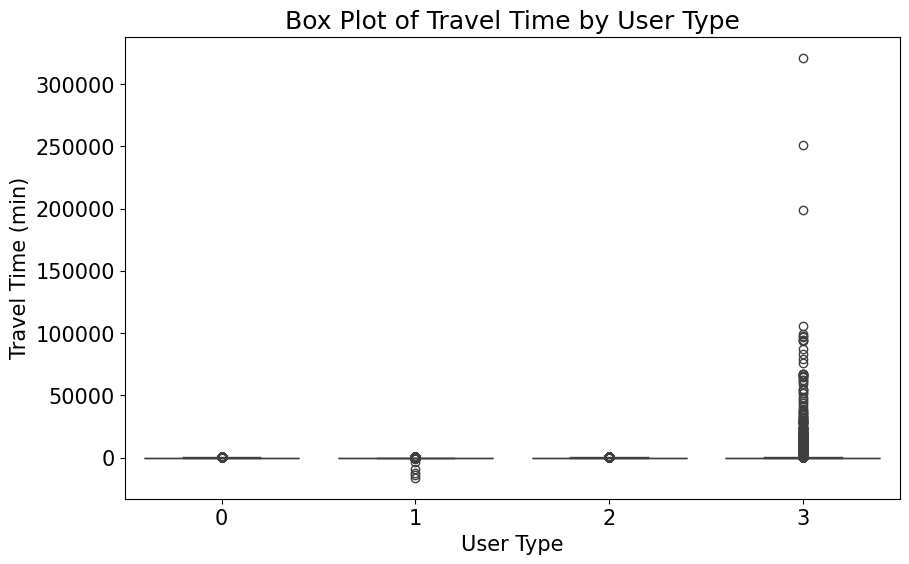

In [41]:
# Box-plot travel_time by user_type
plt.figure(figsize=(10, 6))
sns.boxplot(x='user_type', y='travel_time_min', data=bike_df)
plt.title('Box Plot of Travel Time by User Type')
plt.xlabel('User Type')
plt.ylabel('Travel Time (min)')

plt.show()

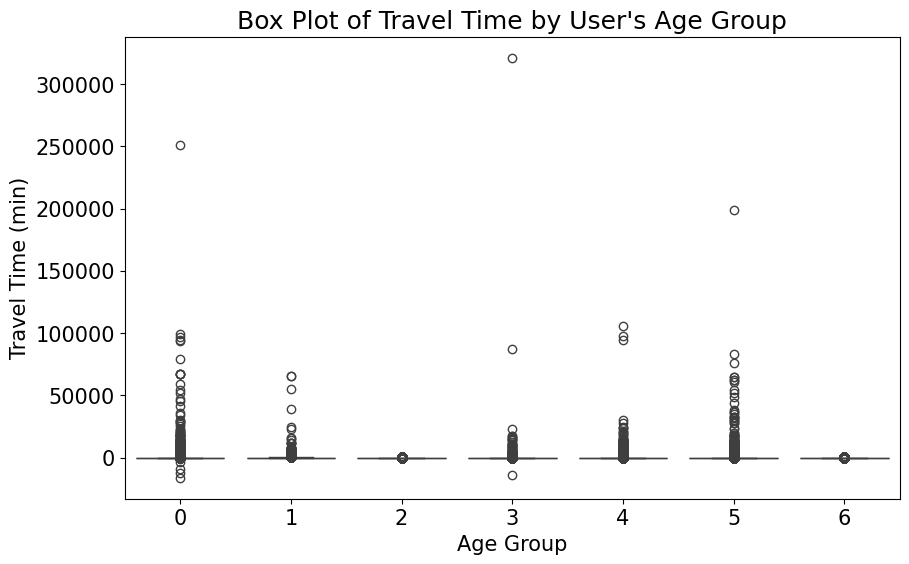

In [42]:
# Box-plot travel_time by ageRange for labeled trips excluding BiciMAD employees
plt.figure(figsize=(10, 6))
sns.boxplot(x='ageRange', y='travel_time_min', data=bike_df)
plt.title("Box Plot of Travel Time by User's Age Group")
plt.xlabel('Age Group')
plt.ylabel('Travel Time (min)')

plt.show()

In [43]:
# Quick descriptive statistics from bike movements
bike_df.describe()

,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,year,month,day,hour,travel_time_min
count,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000,3956191.0000000000
mean,12.1125992147,1.1430004264,12.0997724832,1167.1615826941,96.4622921391,2.3663180064,96.3332599462,2019.0000000000,6.5355676710,15.3065117432,13.6132572972,19.4526930449
std,7.6792352723,0.5058224577,7.6625992947,20373.1818391153,55.8668365663,2.1837700511,55.8671519992,0.0000000000,3.3392431138,8.7973154975,5.7343542161,339.5530306519
min,1.0000000000,0.0000000000,1.0000000000,-969693.0000000000,1.0000000000,0.0000000000,1.0000000000,2019.0000000000,1.0000000000,1.0000000000,0.0000000000,-16161.5500000000
25%,5.0000000000,1.0000000000,5.0000000000,460.0000000000,50.0000000000,0.0000000000,50.0000000000,2019.0000000000,4.0000000000,8.0000000000,9.0000000000,7.6666666667
50%,12.0000000000,1.0000000000,12.0000000000,692.0000000000,92.0000000000,3.0000000000,92.0000000000,2019.0000000000,6.0000000000,15.0000000000,14.0000000000,11.5333333333
75%,19.0000000000,1.0000000000,19.0000000000,1047.0000000000,143.0000000000,4.0000000000,143.0000000000,2019.0000000000,10.0000000000,23.0000000000,18.0000000000,17.4500000000
max,30.0000000000,3.0000000000,30.0000000000,19272889.0000000000,2008.0000000000,6.0000000000,2008.0000000000,2019.0000000000,12.0000000000,31.0000000000,23.0000000000,321214.8166666667


In [44]:
# We have negative time travels, since this is not possible we will remove this data for the labeled user dataset
negative_travel_time = bike_df[bike_df['travel_time_min'] < 0].shape[0]
display(f"% unknown users for year 2019: {(negative_travel_time/bike_df.shape[0])*100}")

'% unknown users for year 2019: 0.0018199323541254707'

In [45]:
# Identify whether there exist duplicate rows based on unique id col_name: '_id'
duplicate_rows = bike_df[bike_df.duplicated(subset='_id', keep=False)]

# Duplicate rows seem to be a one time event during 01/02/2019
print("Duplicate Rows:")
display(f" Tot. #duplicate instances: {duplicate_rows.shape[0]} which  %  accounts for: {((duplicate_rows.shape[0]/2)/bike_df.shape[0])*100} out of full dataset {bike_df.shape[0]}")
display(f"Age Groups with Duplicate instances: {duplicate_rows['ageRange'].unique()}")
display(f"Month with Duplicate instances: {duplicate_rows['month'].unique()}")
display(f"Day with Duplicate instances: {duplicate_rows['day'].unique()}")

# Remove duplicate rows to prevent data leakage
print(f"Full dataset size: {bike_df.shape}")
bike_df = bike_df.drop_duplicates()
print(f"Dataset w/o duplicates: {bike_df.shape}")



Duplicate Rows:


' Tot. #duplicate instances: 312 which  %  accounts for: 0.003943186767271853 out of full dataset 3956191'

'Age Groups with Duplicate instances: [0 4 5 3]'

'Month with Duplicate instances: [2]'

'Day with Duplicate instances: [1]'

Full dataset size: (3956191, 17)
Dataset w/o duplicates: (3956035, 17)


In [46]:
"""
Check values zip_code. It seems we have some empty records, incomplete values and incorrect values
For the moment we will assign dummy value:0 to incorrect + empty values"
"""
# print(bike_df['zip_code'].unique())
print(bike_df['zip_code'].isna().value_counts()/len(bike_df['zip_code'])) # 49% data is nan and it can be appreciated the low data quality for the non nan values.


zip_code
False   0.5062167044
True    0.4937832956
Name: count, dtype: float64


In [47]:
# Seems we will need to further validate if bike dock id are correct or not this points out that dock 2008 should be something 
print(len(bike_df['idunplug_station'].unique()))
print(len(bike_df[bike_df['idunplug_station']==2008]))

214
20


## Filtering Data:
Labeled dataset where user's ageRange is known code != 0   
    - This will be the focus for our study -> labeled_bike_df   
    - We apply extra filter to remove BiciMAD employees user_type : 3 -> labeled_bike_users_df     
    
    
Unlabled dataset where users have an unknown ageRange code : 0 -> unlabeled_bike_df      


In [48]:
"""
Split data labeled/unlabeled age group (ageRange:0 Unknown)
We will focus on the labeled instances"""

print(f"Full dataset size: {bike_df.shape}")

# Unlabeled df based on entire df
unlabeled_bike_df = bike_df[bike_df['ageRange']==0]
print(f"Unlabeled dataset size: {unlabeled_bike_df.shape}")

# Potential filters to be applied to entire dataframe
unknown_user_type = bike_df['user_type']!=0
unknown_travel_time = bike_df['travel_time'] >= 0
unknown_ageRange = bike_df['ageRange']!=0
known_bicimad_users = bike_df['user_type']!=3

# Labeled df based on entire df !Note it includes as well BiciMAD employees 
labeled_bike_df = bike_df[(unknown_user_type)  & (unknown_ageRange) & (unknown_travel_time)]
print(f"Filtered Labeled dataset size: {labeled_bike_df.shape}")


# Labeled df excluding BiciMAD employees, unknown users and negative trips
labeled_bike_users_df = bike_df[(unknown_user_type) & (known_bicimad_users) & (unknown_ageRange) & ((unknown_travel_time))]
print(f"Filtered Labeled users dataset size: {labeled_bike_users_df.shape}")
print(f"Filtered Labeled dataset user_type: {labeled_bike_users_df['user_type'].unique()}")
print(f"Filtered Labeled dataset Age Group: {labeled_bike_users_df['ageRange'].unique()}")
print(f"Filtered Labeled dataset travel_time values: {labeled_bike_users_df['travel_time'].min()}")

Full dataset size: (3956035, 17)
Unlabeled dataset size: (1743744, 17)
Filtered Labeled dataset size: (2212247, 17)
Filtered Labeled users dataset size: (2035412, 17)
Filtered Labeled dataset user_type: [1 2]
Filtered Labeled dataset Age Group: [5 3 4 2 1 6]
Filtered Labeled dataset travel_time values: 0


### Removing Invalid values labeled user dataset

In [49]:
"""
Cleaning trips with unknown stations 2008 that accounts to  0.0007369327092004575% of the data.
Identify 213 different station ids vs 215 from md file, stations 23 and 24 removed on md due to constructions during 2019
"""

remove_unknown_station = ((labeled_bike_users_df[labeled_bike_users_df['idplug_station']==2008].shape[0])/labeled_bike_users_df.shape[0])*100
display(f"%_unknown_station {remove_unknown_station:.6f}")

labeled_bike_users_df = labeled_bike_users_df[labeled_bike_users_df['idplug_station']!=2008]
print(f"labeled_bike_users_df Dataset w/o unknown bike station: {labeled_bike_users_df.shape}")

'%_unknown_station 0.000737'

labeled_bike_users_df Dataset w/o unknown bike station: (2035397, 17)


### Removing Outliers based on Travel time

In [50]:
# Show travel time distribution 
pd.set_option('display.float_format', '{:.10f}'.format)
labeled_bike_users_df['travel_time_min'].describe()

count   2035397.0000000000
mean         14.0354726948
std          16.2991641561
min           0.0000000000
25%           7.5333333333
50%          11.0000000000
75%          15.8333333333
max         359.8333333333
Name: travel_time_min, dtype: float64

In [51]:
# Show travel time deistribution per Age Group
labeled_bike_users_df.groupby(['ageRange'])['travel_time_min'].describe()

,count,mean,std,min,25%,50%,75%,max
ageRange,,,,,,,,
1,5050.0000000000,14.6773333333,19.3236461952,1.1000000000,6.5875000000,10.6833333333,15.9000000000,347.6500000000
2,18068.0000000000,13.5090076378,16.3480857460,0.6000000000,6.3166666667,9.8333333333,15.5333333333,357.8833333333
3,192308.0000000000,14.5755408858,17.6317061116,0.0500000000,7.3833333333,11.0166666667,16.0000000000,359.4666666667
4,1053278.0000000000,13.5986095314,15.5558351435,0.0000000000,7.4666666667,10.8500000000,15.5166666667,359.8333333333
5,745857.0000000000,14.3908229728,16.7120526435,0.0333333333,7.6833333333,11.2166666667,16.1833333333,359.6666666667
6,20836.0000000000,18.7153156396,22.1565167758,0.5666666667,7.8333333333,12.0666666667,19.6666666667,349.5166666667


In [52]:
print("All known user instances per Age Group after removing duplicate and invalid values:")
user_df_with_outliers = labeled_bike_users_df['ageRange'].value_counts()
user_df_with_outliers

All known user instances per Age Group after removing duplicate and invalid values:


ageRange
4    1053278
5     745857
3     192308
6      20836
2      18068
1       5050
Name: count, dtype: int64

In [53]:
"""
Filtering Outliers based on IQR on travel_time.
Known limitation as target Age groups [3,4,5] have similar distribution 
IQR: 15.00 - 7.40 = 7.60
We apply 1.5IQR Rule: 
Q3 + 1.5 * IQR = ~26.4 (Select 30' max allowed outliers) 
Q1 - 1.5 * IQR = 0 (travel_time cannot be negative)

In case other target Age Groups would be taken into account, outlier boundieries need to be reviewed. i.e with 30' we remove 13% data from under represented Age Group 6
"""

print(f"# instance prior removing outliers: {labeled_bike_users_df.shape[0]} ")


# Removing Outliers (Based on 1.5 * IQR):
labeled_bike_users_df = labeled_bike_users_df[labeled_bike_users_df['travel_time_min']<=30]

print("# instances per Age group after removing Outliers:")
display(labeled_bike_users_df['ageRange'].value_counts())

print(f"% Tot. outlier instances removed: {(1-(labeled_bike_users_df.shape[0]/user_df_with_outliers.sum()))*100}\n")
print(f"% Tot. outlier instances removed per Age group:{(1-(labeled_bike_users_df['ageRange'].value_counts()/user_df_with_outliers))*100}\n")
print(f"Tot. # instance after removing outliers: {labeled_bike_users_df.shape[0]} ")

# instance prior removing outliers: 2035397 
# instances per Age group after removing Outliers:


ageRange
4    1014113
5     709982
3     181401
6      18082
2      17061
1       4723
Name: count, dtype: int64

% Tot. outlier instances removed: 4.423461368961434

% Tot. outlier instances removed per Age group:ageRange
4    3.7183915358
5    4.8099032388
3    5.6716309254
6   13.2175081590
2    5.5733894178
1    6.4752475248
Name: count, dtype: float64

Tot. # instance after removing outliers: 1945362 


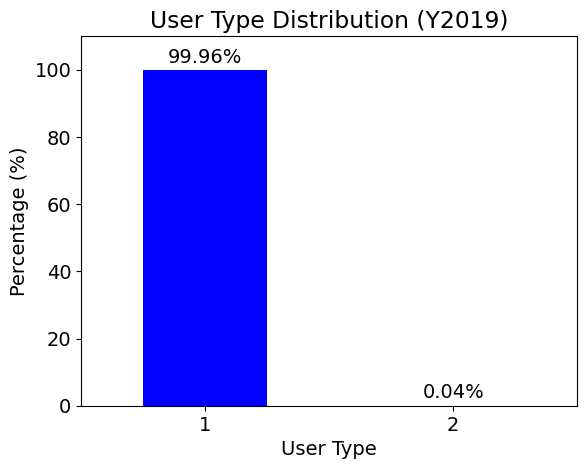

In [54]:
"""User type values after Filtaring Data {1:Annual subscription; 2:occasional user; 3:BiciMAD employee}"""

# User_type distribution
user_type_dist = (labeled_bike_users_df['user_type'].value_counts()/labeled_bike_users_df.shape[0])*100

# Set font size to be further exported for the paper
plt.rcParams.update({'font.size': 14})

# Create barplot
ax = user_type_dist.plot(kind='bar', rot=0, color=['blue'])

# Set ylim to ensure values on top of the bars do not overlap with the graph limits
ax.set_ylim(0, user_type_dist.max() + 10)

# Add values on top of each bar
for i, v in enumerate(user_type_dist):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', color='black')

plt.xlabel('User Type')
plt.ylabel('Percentage (%)')
plt.title('User Type Distribution (Y2019)')

# Save the plot to a PDF file
plt.savefig('labeled_user_type_distribution.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


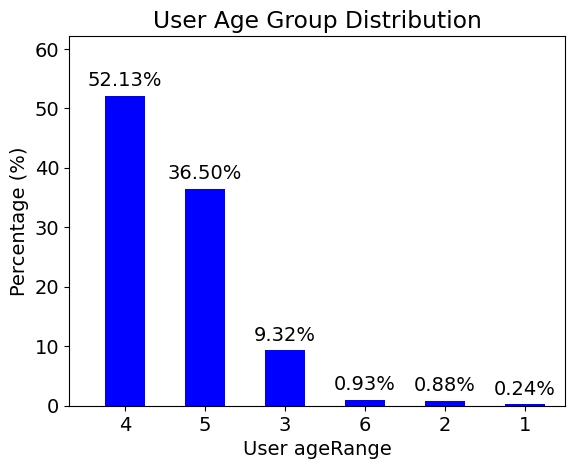

In [55]:
"""User ageRange values after Filtering Data: {1:[0:16]; 2:[17:18]; 3:[19:26]; 4:[27:40]; 5:[41:65]; 6:[66:]}"""

# User Age group distribution w/o filtering
user_age_dist = (labeled_bike_users_df['ageRange'].value_counts()/labeled_bike_users_df.shape[0])*100 

# Set font size to be further exported for the paper
plt.rcParams.update({'font.size': 14})

# Create barplot
ax = user_age_dist.plot(kind='bar', rot=0, color=['blue'])

# Set ylim to ensure values on top of the bars do not overlap with the graph limits
ax.set_ylim(0, user_age_dist.max() + 10)

# Add values on top of each bar
for i, v in enumerate(user_age_dist):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom', color='black')

# Adjust x-axis limits if necessary
ax.set_xlim(-0.7, len(user_age_dist) - 0.5)

plt.xlabel('User ageRange')
plt.ylabel('Percentage (%)')
plt.title('User Age Group Distribution')

# Save the plot to a PDF file
plt.savefig('labeled_user_age_group_distribution_all.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()


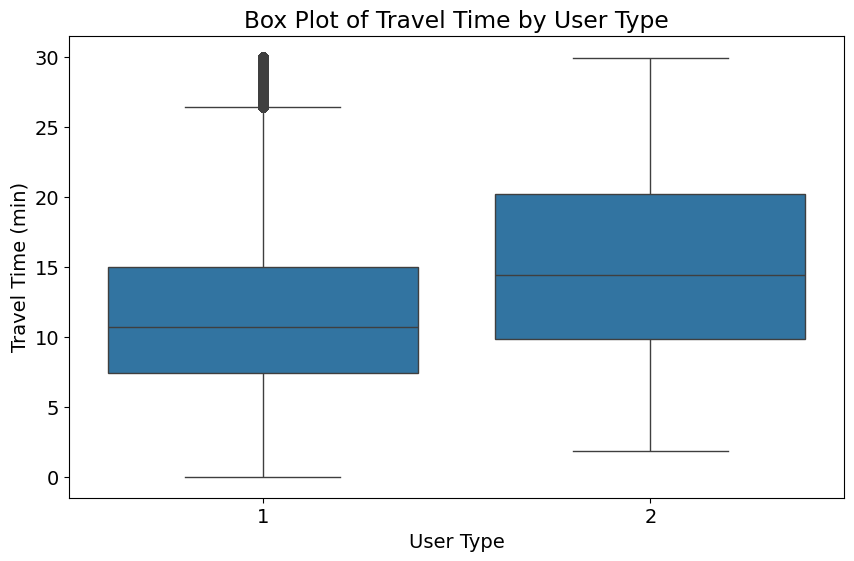

In [57]:
# Box-plot travel_time by user_type

# Set font size to be further exported for the paper
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
sns.boxplot(x='user_type', y='travel_time_min', data=labeled_bike_users_df)
plt.title('Box Plot of Travel Time by User Type')
plt.xlabel('User Type')
plt.ylabel('Travel Time (min)')


# Save the plot to a PDF file
plt.savefig('box_plot_travel_time_user_type_all.pdf', format='pdf', bbox_inches='tight')

plt.show()

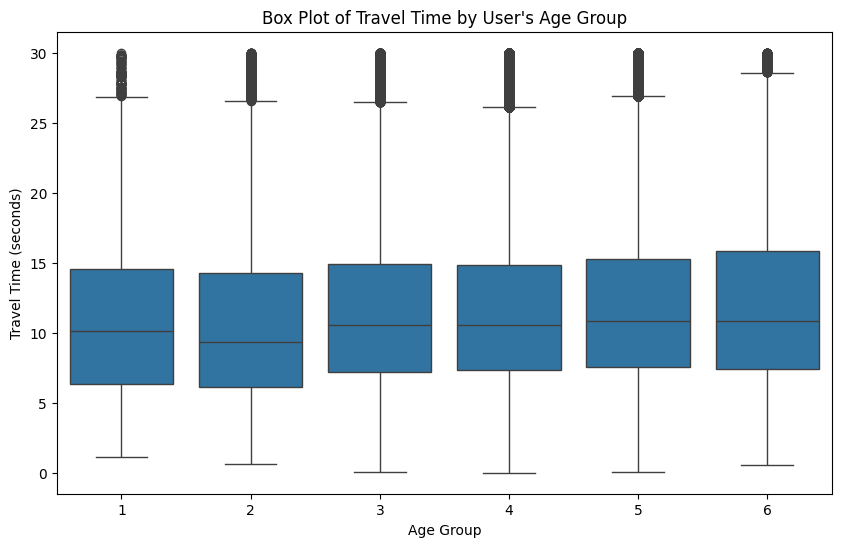

In [82]:
# Box-plot travel_time by ageRange
plt.figure(figsize=(10, 6))
sns.boxplot(x='ageRange', y='travel_time_min', data=labeled_bike_users_df)
plt.title("Box Plot of Travel Time by User's Age Group")
plt.xlabel('Age Group')
plt.ylabel('Travel Time (seconds)')

plt.show()

## EDA Distribution

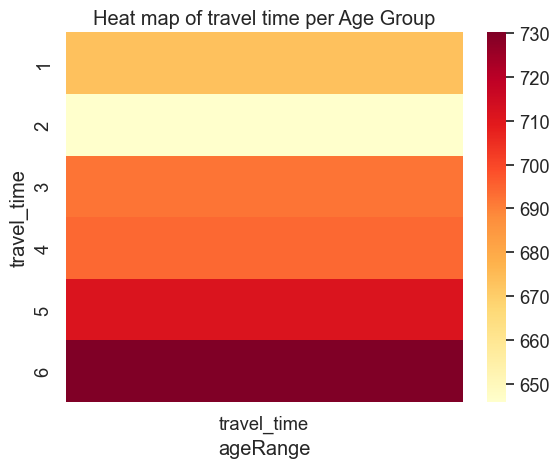

In [105]:
# To be used with full merged dataframe
plot_heatmap_age(labeled_bike_users_df, 'ageRange', 'travel_time','Heat map of travel time per Age Group')

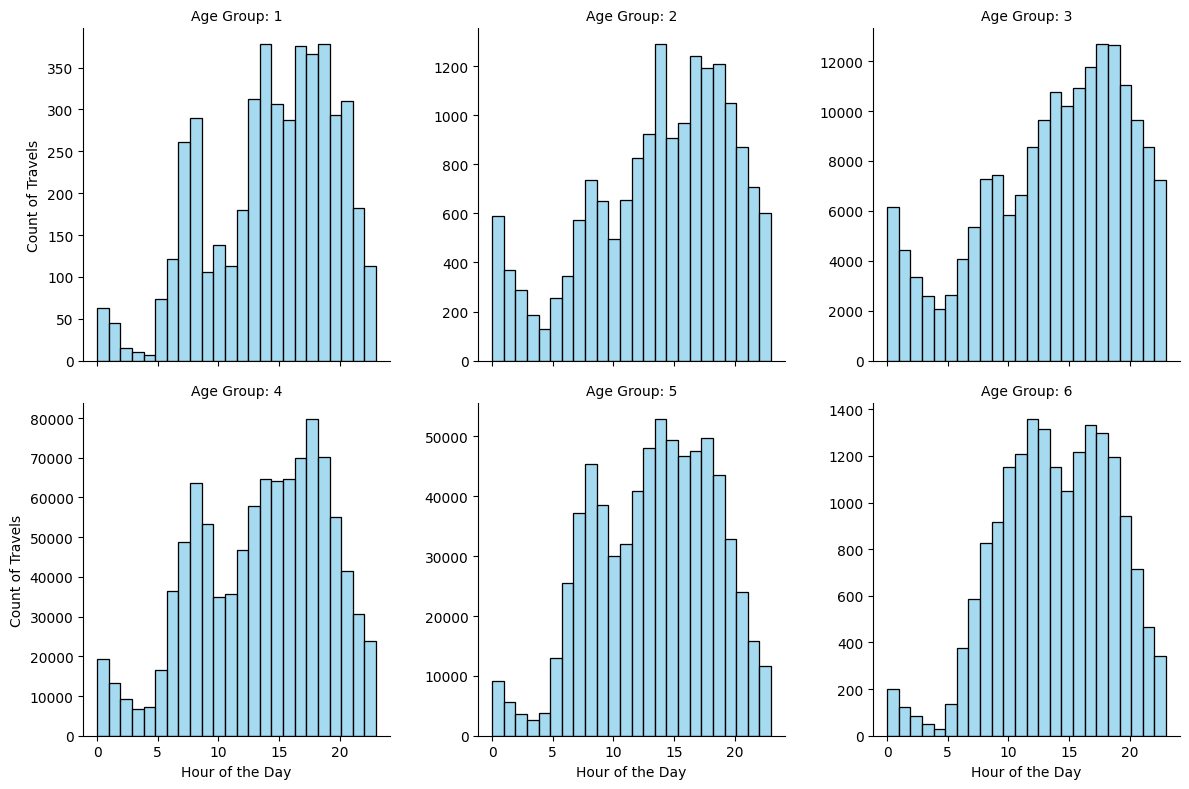

In [83]:
"""
User ageRange values: {0:Unknown; 1:[0:16]; 2:[17:18]; 3:[19:26]; 4:[27:40]; 5:[41:65]; 6:[66:]}
"""

# Display most popular hours of the day re-scaled to better appreciate each group distribution
popular_hours = labeled_bike_users_df[['_id', 'hour', 'ageRange']]

# Create graph per ageRange showing the count of trips per hour
g = sns.FacetGrid(popular_hours, col='ageRange', col_wrap=3, height=4, sharey=False)
g.map(sns.histplot, 'hour', bins=24, stat='count', common_norm=False, color='skyblue')

# Set titles and labels
g.set_axis_labels('Hour of the Day', 'Count of Travels')
g.set_titles('Age Group: {col_name}')


# Show the plot
plt.show()

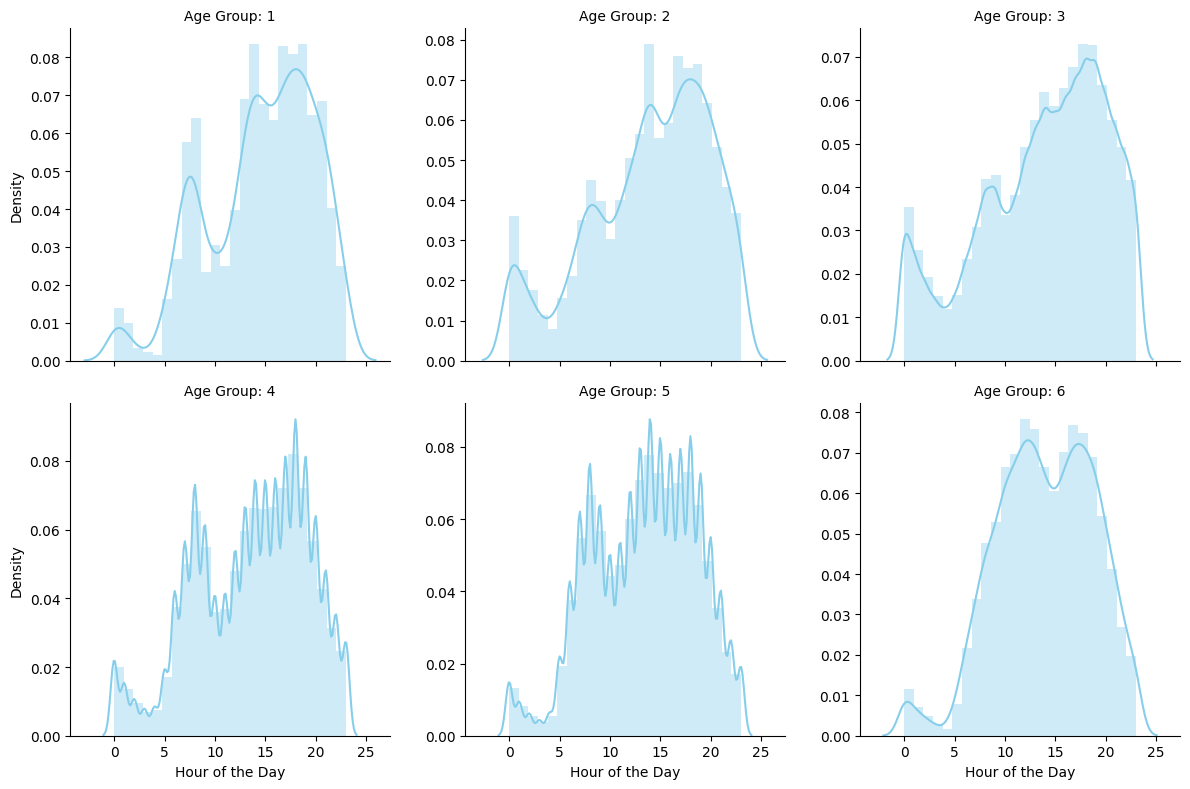

In [7]:
"""
User ageRange values: {0:Unknown; 1:[0:16]; 2:[17:18]; 3:[19:26]; 4:[27:40]; 5:[41:65]; 6:[66:]}
"""

# Display most popular hours of the day re-scaled to better appreciate each group distribution
popular_hours = labeled_bike_users_df[['_id', 'hour', 'ageRange']]

# Create graph per ageRange showing the count of trips per hour
g = sns.FacetGrid(popular_hours, col='ageRange', col_wrap=3, height=4, sharey=False)

# Map distplot with normal distribution fit
g.map(sns.histplot, 'hour', bins=24, kde=True, stat='density', color='skyblue') # To be re-run
#g.map(sns.distplot, 'hour', bins=24, kde=True,  color='skyblue')


# Set titles and labels
g.set_axis_labels('Hour of the Day', 'Density')
g.set_titles('Age Group: {col_name}')

# Show the plot
plt.show()


## Feature creation

In [91]:
# Function to calculate the cost for each ride based on BiciMAD policy (2019)
# Reference inspiration on https://github.com/rameerez/bicimad-data-analysis/tree/master
    
def ride_revenue(user_type, travel_time):
    """
	BiciMAD ride tariffs per user type as of 2019:
    Calculations done over 'travel_time' feature which is in Seconds.
	* Annual user: user_type = 1
    	- Exception 0 Eur. if ride less than 2 min. (Case bike is broken)
		- Baseline 0.5 Eur. for first 30 min.
		- Additional 0.6 Eur. for next 30 min. until 2h.
		- Over 2 h. 4 Eur. for each additional hour.
	* Occasional user: user_type = 2
    	- Exception 0 Eur. if ride less than 2 min. (Case bike is broken)
		- Baseline 2 Eur. for First 1h.
		- Additional 4 Eur. for next hour until 2h.
		- Over 2 h. 4 Eur. for each additional hour.
	* BiciMAD Employee: user_type = 3
		- No revenue
    """
    revenue_list = []

    for u_type, t_time in zip(user_type, travel_time):
        revenue = 0

        if u_type == 1:
            if t_time <= 120:
                revenue = 0
            elif t_time <= 1800:
                revenue = 0.5
            elif t_time > 1800:
                revenue = 0.5 + (0.6 * math.ceil((t_time - 1800) / 1800))
            if t_time >= 7200:
                revenue += 4 * math.ceil((t_time - 7200) / 3600)

        elif u_type == 2:
            if t_time <= 120:
                revenue = 0
            elif t_time <= 3600:
                revenue = 2
            elif t_time > 3600:
                revenue = 2 + 4
            if t_time > 7200:
                revenue += 4 * math.ceil((t_time - 7200) / 3600)

        revenue_list.append(revenue)

    return revenue_list



In [92]:
# Adding revenue per trip based on user_type
labeled_bike_users_df['travel_revenue'] = ride_revenue(labeled_bike_users_df['user_type'], labeled_bike_users_df['travel_time'])

In [93]:
print(labeled_bike_users_df.shape)

display(labeled_bike_users_df.head())

(1945362, 18)


,_id,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,unplug_hourTime,zip_code,temp_unplug_hourTime,year,month,day,hour,travel_time_min,travel_revenue
1,5c4b07ea2f38432e007daaba,a18550d468153bb8e1808d4f0a85955579951832772996...,10,1,1,415,133,5,36,2019-01-01T00:00:00.000+0100,28005,2019-01-01 00:00:00+01:00,2019,1,1,0,6.916667,0.5
3,5c4b07ea2f38432e007daabd,5922b4a1a2591161ebf1ad66f42f52cc7796f3754c2c76...,18,1,6,417,105,3,155,2019-01-01T00:00:00.000+0100,28009,2019-01-01 00:00:00+01:00,2019,1,1,0,6.950000,0.5
4,5c4b07ea2f38432e007daabe,ed1c1a22c120e7d42cc522c33ab41db549791f3914b273...,4,1,12,448,51,4,44,2019-01-01T00:00:00.000+0100,28005,2019-01-01 00:00:00+01:00,2019,1,1,0,7.466667,0.5
7,5c4b07ea2f38432e007daac2,b70eb1a71e53c6351b4835f618a459886e2045a44635e4...,17,1,11,468,100,5,171,2019-01-01T00:00:00.000+0100,28028,2019-01-01 00:00:00+01:00,2019,1,1,0,7.800000,0.5
8,5c4b07ea2f38432e007daac4,1ad9b018315170d824bb396889046eaeff8ce0a0be46b3...,13,1,2,149,67,4,65,2019-01-01T00:00:00.000+0100,28009,2019-01-01 00:00:00+01:00,2019,1,1,0,2.483333,0.5


In [94]:
labeled_bike_users_df['travel_revenue'].unique()

array([0.5, 2. , 0. ])

### Export BSS usage processed data
   
To be further merged with further processed datasets

In [ ]:
# Save labeled_bike_users_df to be further merged with different data sources
labeled_bike_users_df.to_csv('export_file', index=False, sep = ';')